In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Following Jon Snow and discover the poisoned wells

 * geopandas, shapely, folium
 
### Additional reading related to this epidemic
* "Loss in the Time of Cholera: Long-run Impact of a DiseaseEpidemic on the Urban Landscape" http://economics.mit.edu/files/10841/
* "Data. (re)Imagined." https://medium.com/matter-driven-narrative/data-re-imagined-8feb517faf06
* "Lesson on Infographics from John Snow (no, not that Jon Snow)" https://medium.com/@juniageisler/lesson-on-infographics-from-john-snow-no-not-that-jon-snow-4ae6672bb64
* "Looking Beyond the Pump Handle - 
What a Cholera Outbreak can Teach us about Homeland Security." https://medium.com/homeland-security/looking-beyond-the-pump-handle-dc56217f8e32

See an earlier solution of this assignment in the public directory Examples/Shapes-Maps-Coordinates!


In [2]:
import json
import scipy as scp
import numpy as np
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt


import folium
from folium import GeoJson
from folium.plugins import HeatMap

import geopandas as gpd
#from folium import pluginsa
from collections import Counter
from scipy.stats import gaussian_kde

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


FS = 15 # fontsize for plots

# Introduction into handling geographical data

[John Snow](https://en.wikipedia.org/wiki/John_Snow) was an English physician, who was first to trace the source of a cholera outbreak in London's Soho district in 1854 using data visualization. In the following exercises, we are going to reconstruct the map of Snow with modern tools and explore some ideas of geographic data analysis.


Further reading:
* https://en.wikipedia.org/wiki/1854_Broad_Street_cholera_outbreak
* https://www1.udel.edu/johnmack/frec682/cholera/cholera2.html
* https://www.theguardian.com/news/datablog/interactive/2013/mar/15/cholera-map-john-snow-recreated

The shapefile that will be used in these exercises are located at http://donboyes.com/2011/10/14/john-snow-and-serendipity/, but they are already downloaded into the `/v/courses/dataesp2023.public/Datasets/D-Shapes-Maps-Coordinates/shapes` directory.

---
## Exercise 1

Load the death and the pump dataset into a tabular format! Have a look at the dataset's structure! The pump dataset contains the locations of wells. (Wells were used to obtain water for drinking, cooking etc. )

*The format of the files is called [shapefile](https://en.wikipedia.org/wiki/Shapefile), which is a format that is easily readable by the most common GIS (Geographic Information System) softwares. Shapefiles consist of many files, some of which store the geographic information, some the coordinate system description, some the additional attributes of the geographical objects. [geopandas](http://geopandas.org/) is able to read shapefiles natively into its base class GeoDataFrame, which has a similar API to that of `pandas` `DataFrames`. This is convenient, because we can use all of our previous knowledge of `pandas`.*

It is sometimes worth to have a look at a shapefile's content quickly. For Linux, [QGIS](https://www.qgis.org/en/site/about/index.html) is a powerful free GIS system, try it at home!

In [3]:
deaths = gpd.read_file('./shapes/deaths_gcs.shp')
deaths.head()

,OBJECTID,X,Y,geometry
0,1,13.588010,11.095600,POINT (-0.13585 51.51295)
1,2,9.878124,12.559180,POINT (-0.13877 51.51371)
2,3,14.653980,10.180440,POINT (-0.13502 51.51249)
3,4,15.220570,9.993003,POINT (-0.13457 51.51239)
4,5,13.162650,12.963190,POINT (-0.13617 51.51387)


In [4]:
pumps = gpd.read_file('./shapes/pumps_gcs.shp')
pumps.head()

,OBJECTID,X,Y,geometry
0,1,8.651201,17.891600,POINT (-0.13962 51.51630)
1,2,10.984780,18.517851,POINT (-0.13773 51.51658)
2,3,13.378190,17.394541,POINT (-0.13585 51.51602)
3,4,14.879830,17.809919,POINT (-0.13463 51.51620)
4,5,8.694768,14.905470,POINT (-0.13966 51.51487)


---
## Exercise 2

Extract the latitudes and the longitudes for each row in both datasets as additional columns!

*In a `GeoDataFrame`, the `geometry` column contains geometry objects from the [`shapely`](https://toblerity.org/shapely/index.html) library. These objects have coordinate attributes, that is where latitude and longitude values are stored.*

The 'X' and 'Y' columns are coordinates in an arbitrary coordinate system and usually not part of a *shp* file. 

Project your points into a coordinate system where you can measure real distances (using e.g. `pyproj`), then create a meaningul visualization of the data!

*It is crucial to use the appropriate coordinate system for your purposes. For this exercise, the spherical coordinate system of lon, lat values is not convenient, since we cannot calculate distances in meters as easily as we would in a Cartesian coordinate system. Because of the Earth's shape, most projections distort distances at certain latitudes and longitudes.*

In GIS, different coordinate systems are called CRS (Coordinate Reference System), and have patented codes that define the origin, the projection etc. The usual lon, lat pairs are called the WGS84 system (you will need to find its epsg code first). A good choice for a Cartesian system is for example the Pseudo-Mercator projection. The `pyproj` library is especially lightweight to use in Python.

In [5]:
# Add additional Lat-Long columns to deaths and pumps GeoDFs
# Use the `geometry` column to get coordinate values
pumps['geometry'].head()

0    POINT (-0.13962 51.51630)
1    POINT (-0.13773 51.51658)
2    POINT (-0.13585 51.51602)
3    POINT (-0.13463 51.51620)
4    POINT (-0.13966 51.51487)
Name: geometry, dtype: geometry

In [6]:
#modified datafile
deaths['lat'] = [xy.coords[0][1] for xy in deaths['geometry']]
deaths['long'] = [xy.coords[0][0] for xy in deaths['geometry']]
deaths.head()

,OBJECTID,X,Y,geometry,lat,long
0,1,13.588010,11.095600,POINT (-0.13585 51.51295),51.512950,-0.135851
1,2,9.878124,12.559180,POINT (-0.13877 51.51371),51.513712,-0.138770
2,3,14.653980,10.180440,POINT (-0.13502 51.51249),51.512488,-0.135016
3,4,15.220570,9.993003,POINT (-0.13457 51.51239),51.512389,-0.134570
4,5,13.162650,12.963190,POINT (-0.13617 51.51387),51.513870,-0.136173


In [7]:
pumps['lat'] = [xy.coords[0][1] for xy in pumps['geometry']]
pumps['long'] = [xy.coords[0][0] for xy in pumps['geometry']]
pumps.head()

,OBJECTID,X,Y,geometry,lat,long
0,1,8.651201,17.891600,POINT (-0.13962 51.51630),51.516303,-0.139621
1,2,10.984780,18.517851,POINT (-0.13773 51.51658),51.516582,-0.137734
2,3,13.378190,17.394541,POINT (-0.13585 51.51602),51.516019,-0.135846
3,4,14.879830,17.809919,POINT (-0.13463 51.51620),51.516205,-0.134632
4,5,8.694768,14.905470,POINT (-0.13966 51.51487),51.514867,-0.139665


In [8]:
deaths_proj = deaths['geometry'].to_crs({'init': 'epsg:3857'})
pumps_proj = pumps['geometry'].to_crs({'init': 'epsg:3857'})

In [9]:
# Add them to the `deaths` and `pumps` GeoDFs
deaths['lat_proj'] = [death.coords[0][1] for death in deaths_proj]
deaths['long_proj'] = [death.coords[0][0] for death in deaths_proj]
deaths.head()

,OBJECTID,X,Y,geometry,lat,long,lat_proj,long_proj
0,1,13.588010,11.095600,POINT (-0.13585 51.51295),51.512950,-0.135851,6.712535e+06,-15122.865526
1,2,9.878124,12.559180,POINT (-0.13877 51.51371),51.513712,-0.138770,6.712672e+06,-15447.817092
2,3,14.653980,10.180440,POINT (-0.13502 51.51249),51.512488,-0.135016,6.712453e+06,-15029.922201
3,4,15.220570,9.993003,POINT (-0.13457 51.51239),51.512389,-0.134570,6.712435e+06,-14980.263116
4,5,13.162650,12.963190,POINT (-0.13617 51.51387),51.513870,-0.136173,6.712700e+06,-15158.660025


In [10]:
pumps['lat_proj'] = [pump.coords[0][1] for pump in pumps_proj]
pumps['long_proj'] = [pump.coords[0][0] for pump in pumps_proj]
pumps.head()

,OBJECTID,X,Y,geometry,lat,long,lat_proj,long_proj
0,1,8.651201,17.891600,POINT (-0.13962 51.51630),51.516303,-0.139621,6.713135e+06,-15542.522537
1,2,10.984780,18.517851,POINT (-0.13773 51.51658),51.516582,-0.137734,6.713185e+06,-15332.510539
2,3,13.378190,17.394541,POINT (-0.13585 51.51602),51.516019,-0.135846,6.713084e+06,-15122.307524
3,4,14.879830,17.809919,POINT (-0.13463 51.51620),51.516205,-0.134632,6.713117e+06,-14987.129954
4,5,8.694768,14.905470,POINT (-0.13966 51.51487),51.514867,-0.139665,6.712878e+06,-15547.419660


In [11]:
lat_c = np.mean([np.mean(deaths.lat_proj), np.mean(pumps.lat_proj)])
long_c = np.mean([np.mean(deaths.long_proj), np.mean(pumps.long_proj)])

In [12]:
deaths['lat_proj_rs'] = deaths.lat_proj - lat_c
deaths['long_proj_rs'] = deaths.long_proj - long_c
deaths.head()

,OBJECTID,X,Y,geometry,lat,long,lat_proj,long_proj,lat_proj_rs,long_proj_rs
0,1,13.588010,11.095600,POINT (-0.13585 51.51295),51.512950,-0.135851,6.712535e+06,-15122.865526,-68.666870,70.807126
1,2,9.878124,12.559180,POINT (-0.13877 51.51371),51.513712,-0.138770,6.712672e+06,-15447.817092,67.771569,-254.144440
2,3,14.653980,10.180440,POINT (-0.13502 51.51249),51.512488,-0.135016,6.712453e+06,-15029.922201,-151.204962,163.750451
3,4,15.220570,9.993003,POINT (-0.13457 51.51239),51.512389,-0.134570,6.712435e+06,-14980.263116,-168.880773,213.409536
4,5,13.162650,12.963190,POINT (-0.13617 51.51387),51.513870,-0.136173,6.712700e+06,-15158.660025,95.896972,35.012627


In [13]:
pumps['lat_proj_rs'] = pumps.lat_proj - lat_c
pumps['long_proj_rs'] = pumps.long_proj - long_c
pumps.head()

,OBJECTID,X,Y,geometry,lat,long,lat_proj,long_proj,lat_proj_rs,long_proj_rs
0,1,8.651201,17.891600,POINT (-0.13962 51.51630),51.516303,-0.139621,6.713135e+06,-15542.522537,531.187251,-348.849884
1,2,10.984780,18.517851,POINT (-0.13773 51.51658),51.516582,-0.137734,6.713185e+06,-15332.510539,581.117676,-138.837886
2,3,13.378190,17.394541,POINT (-0.13585 51.51602),51.516019,-0.135846,6.713084e+06,-15122.307524,480.447063,71.365128
3,4,14.879830,17.809919,POINT (-0.13463 51.51620),51.516205,-0.134632,6.713117e+06,-14987.129954,513.642780,206.542698
4,5,8.694768,14.905470,POINT (-0.13966 51.51487),51.514867,-0.139665,6.712878e+06,-15547.419660,274.242118,-353.747007


---
## Exercise 3

How many deaths were within a given radius around the wells? Test for a series of radiuses. 

In [14]:
# Calculate distances of all deaths from all pumps individually
# dist : dictionary 
#   - shape : N keys, M values per keys
#     N : number of pumps
#     M : total number of deaths
distance = {}
for _, p in pumps.iterrows():
    # Use Euclidean distance
    distance[p.OBJECTID] = sorted([np.sqrt((p.lat_proj_rs - d.lat_proj_rs)**2 + (p.long_proj_rs - d.long_proj_rs)**2) \
                               for _, d in deaths.iterrows()])  

In [15]:
# Search for the closest and furthest death from any pump
min_r = np.min([distance[i] for i in range(1, len(distance)+1)])
max_r = np.max([distance[i] for i in range(1, len(distance)+1)])

In [16]:
radius = np.linspace(min_r, max_r, 1000)
# Count number of death in specific radius
dist_count = {}
for idx, dists in distance.items():
    dist_count[idx] = [np.sum([d < r for d in dists]) for r in radius]

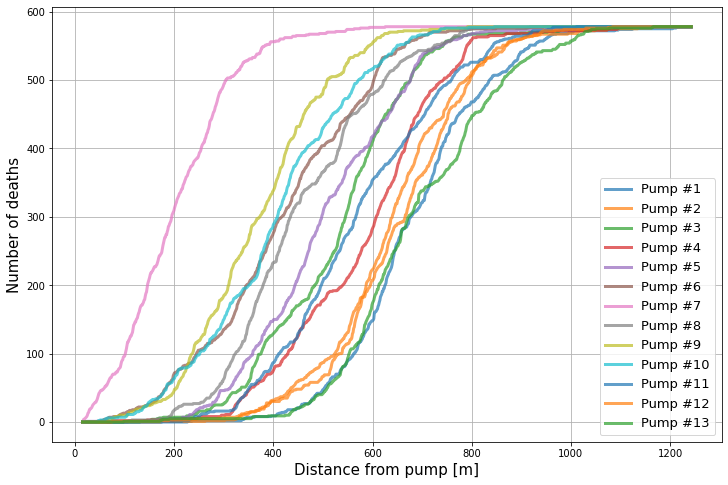

In [17]:
plt.figure(figsize=(12,8))
for idx, dists in dist_count.items():
    plt.plot(radius, dists, label=f'Pump #{idx}', lw=3, alpha=0.7)
plt.xlabel('Distance from pump [m]', fontsize=FS)
plt.ylabel('Number of deaths', fontsize=FS)
plt.legend(loc='lower right', fontsize=FS-2)
plt.grid()
plt.show()

---
## Exercise 4

Put both the deaths and the pumps on a zoomable map that has a base layer from a tile server different from that of the default settings of your chosen method. Set the appropriate map center and zoom level. Use different markers for the deaths and the pumps datasets.

*Try folium in Python, or Leaflet in R or JS. Display the map here in the notebook.*

In [18]:
# Creating a Folium map object
# Here, we should use the original spherical coordinates!
# --------
# Center the map in a spherical coordinate system on the
# mean of the deaths' and pumps' location
lat_c = np.mean([np.mean(deaths.lat), np.mean(pumps.lat)])
long_c = np.mean([np.mean(deaths.long), np.mean(pumps.long)])

# Since we should use a different tile server, than the default 'OpenStreetMap',
# here I am using CartoDB's Positron map style, because this resembles mostly
# at the famous map of John Snow, inserted into the head of the notebook above
#
# In this variable name, JS stands for John Snow, and absolutely not for JavaScript
JS_map = folium.Map(location=[lat_c, long_c], zoom_start=17, tiles='CartoDB Positron')

# Mark deaths on map
for _, death in deaths.iterrows():
    marker = folium.Marker(location=[death.lat, death.long],
                           icon=folium.Icon(icon='death', prefix='fa', color='black'),
                           popup='Death #{0}'.format(death.OBJECTID))
    marker.add_to(JS_map)

# Mark pumps on map
for _, pump in pumps.iterrows():
    marker = folium.Marker(location=[pump.lat, pump.long],
                           icon=folium.Icon(icon='glyphicon-tint', color='blue'),
                           popup='Pump #{0}'.format(pump.OBJECTID))
    marker.add_to(JS_map)

display(JS_map)

---
## Exercise 5

Calculate the Voronoi cells for the pumps, and count the number of deaths falling into each of the cells.  Create a bar chart of the number of deaths in each cell. Pinpoint the possible source of the infection.

*Store the Voronoi cells in a GeoDataFrame, then you can easily do a spatial join (e.g. testing whether a polygon in the Voronoi dataframe contains a point from the death dataframe).*

In [19]:
X_d = deaths.lat_proj_rs.values
Y_d = deaths.long_proj_rs.values

X_p = pumps.lat_proj_rs.values
Y_p = pumps.long_proj_rs.values

In [20]:
# Calculate spatial bounds of available data
min_x = np.min(np.concatenate((X_d, X_p)))
max_x = np.max(np.concatenate((X_d, X_p)))
min_y = np.min(np.concatenate((Y_d, Y_p)))
max_y = np.max(np.concatenate((Y_d, Y_p)))

# Calculate spatial size of data
size_x = max_x - min_x
size_y = max_y - min_y

vor = scp.spatial.Voronoi(np.vstack([X_p, Y_p]).T)

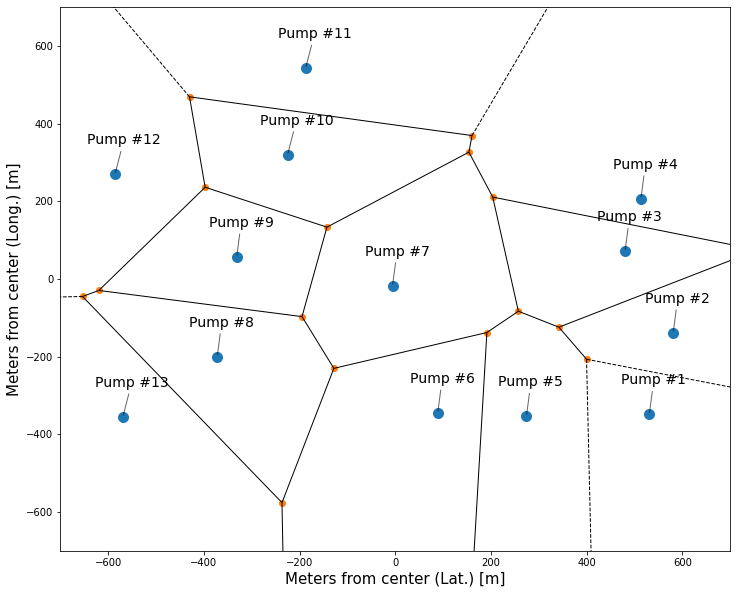

In [21]:
# Visualize the Voronoi cells
fig, axes = plt.subplots(figsize=(12,10))

# Scipy's built-in Voronoi cell visualizator
scp.spatial.voronoi_plot_2d(vor, point_size=20, ax=axes)

# Annotate pumps
for _, p in pumps.iterrows():
    axes.annotate('Pump #{0}'.format(p.OBJECTID),
                  xy=(p.lat_proj_rs, p.long_proj_rs), xycoords='data',
                  xytext=(-28, 30), textcoords='offset points', size='14',
                  arrowprops=dict(arrowstyle='-', color='black', alpha=0.6))
plt.xlabel('Meters from center (Lat.) [m]', fontsize=FS)
plt.ylabel('Meters from center (Long.) [m]', fontsize=FS)
plt.xlim(-700,700)
plt.ylim(-700,700)
plt.show()

### Finding death count in Voronoi cells


In [22]:
# Creating the KD-Tree for the pumps
voronoi_kdtree = scp.spatial.cKDTree(np.vstack([X_p, Y_p]).T)

In [23]:
# Finding the closest pump neighbour of deaths
closest_pump_dist, closest_pump_regions = voronoi_kdtree.query(np.vstack([X_d, Y_d]).T)

In [24]:
# Choose distinct colors for the deaths in different
# Voronoi cells from a colormap
def choose_color(regions, cmap=mp.cm.jet_r):
    region_idx = np.unique(regions)
    m = scp.interpolate.interp1d([min(region_idx), max(region_idx)], [0,1])
    
    colors = {r: cmap(m(r)) for r in region_idx}
    
    colors_arr = []
    for d in regions:
        colors_arr.append(colors[d])
        
    return np.array(colors_arr)

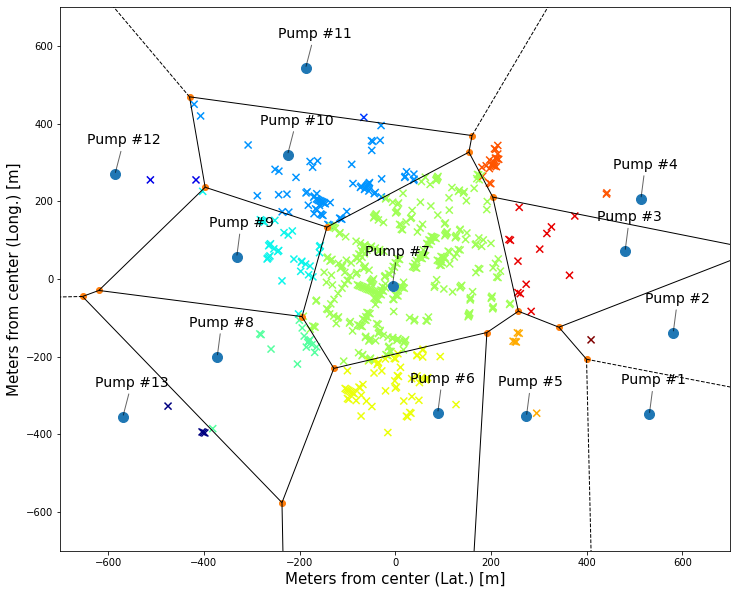

In [25]:
# Visualize the Voronoi cells
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10))

axes.scatter(X_d, Y_d, c=choose_color(closest_pump_regions), marker='x', s=50)

# Scipy's built-in Voronoi cell visualizator
scp.spatial.voronoi_plot_2d(vor, point_size=20, ax=axes)
# Annotate pumps
for _, p in pumps.iterrows():
    axes.annotate('Pump #{0}'.format(p.OBJECTID),
                  xy=(p.lat_proj_rs, p.long_proj_rs), xycoords='data',
                  xytext=(-28, 30), textcoords='offset points', size='14',
                  arrowprops=dict(arrowstyle='-', color='black', alpha=0.6))
axes.set_xlabel('Meters from center (Lat.) [m]', fontsize=FS)
axes.set_ylabel('Meters from center (Long.) [m]', fontsize=FS)
plt.xlim(-700,700)
plt.ylim(-700,700)
plt.show()


Sadly the `cKDTree` method is unable to label regions correctly, and can't handle the case when there are Voronoi cells without test points. To create a usable dataset beyond a good-looking visualization, we have to use some point-in-polygon searching algorithm to identify and count deaths in the corresponding Voronoi cells.

Since some of the Voronoi cells are "unbounded/infinte polygons" - polygons with missing edges, we need to turn them first into "real/finite polygons". Using a function from GitHub at we can create these missing edges.\
Source: [Github](https://gist.github.com/pv/8036995)

In [26]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [27]:
finite_regions, finite_vertices = voronoi_finite_polygons_2d(vor)

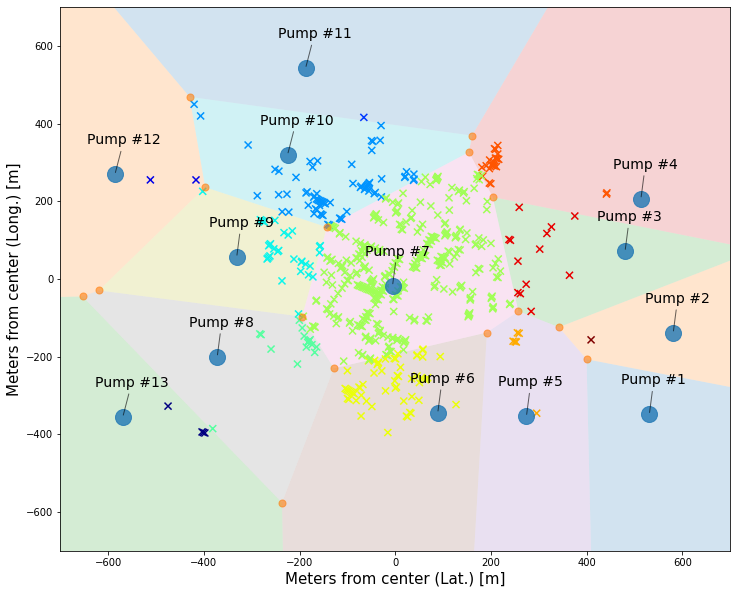

In [28]:
# Visualize the Voronoi cells
fig, axes = plt.subplots(figsize=(12,10))

# Color Voronoi cells
for idx, region in enumerate(finite_regions):
    polygon = finite_vertices[region]
    plt.fill(*zip(*polygon), alpha=0.2)

# Mark cell vertices
axes.scatter(finite_vertices[:,0], finite_vertices[:,1], c='tab:orange', s=50, alpha=0.6, zorder=3)

# Mark pumps
axes.scatter(X_p, Y_p, c='C0', s=16**2, alpha=0.8, zorder=3)

# Mark deaths
axes.scatter(X_d, Y_d, c=choose_color(closest_pump_regions), marker='x', s=50, zorder=2)

# Annotate pumps
for _, p in pumps.iterrows():
    axes.annotate('Pump #{0}'.format(p.OBJECTID),
                  xy=(p.lat_proj_rs, p.long_proj_rs), xycoords='data',
                  xytext=(-28, 30), textcoords='offset points', size='14',
                  arrowprops=dict(arrowstyle='-', color='black', alpha=0.6))
axes.set_xlabel('Meters from center (Lat.) [m]', fontsize=FS)
axes.set_ylabel('Meters from center (Long.) [m]', fontsize=FS)
plt.xlim(-700,700)
plt.ylim(-700,700)
plt.show()

In [29]:
# Initialize the counter for each pumps
deaths_near_pumps = {i+1: 0 for i in range(len(pumps))}

death_coords = np.vstack([X_d, Y_d]).T

# Loop through regions and count how many deaths are in them
for idx, r in enumerate(finite_regions):
    # Handle the current Voronoi cell as a shapely Polygon
    polygon = Polygon([finite_vertices[v] for v in r])
    for d in death_coords:
        # Handle the location of the current death as a shapely Point
        point = Point(d)
        
        # If the polygon cointains the point, increment the counter
        # of the current pump/cell
        if polygon.contains(point):
            deaths_near_pumps[idx+1] += 1
            
# death_near_pumps_arr
dnp_arr = np.array(list(deaths_near_pumps.items())).T

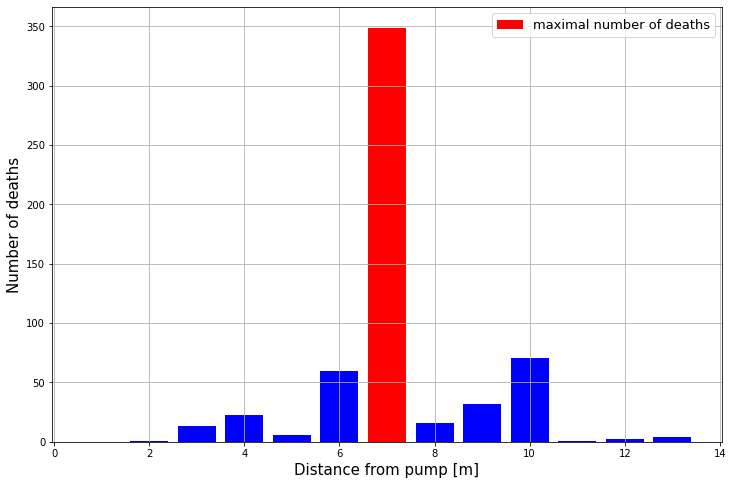

In [30]:
plt.figure(figsize=(12,8))
plt.bar(dnp_arr[0], dnp_arr[1], color='b')
plt.bar(dnp_arr[0][np.argmax(dnp_arr[1])], np.max(dnp_arr[1]), color='red', label='maximal number of deaths')
plt.xlabel('Distance from pump [m]', fontsize=FS)
plt.ylabel('Number of deaths', fontsize=FS)
plt.legend(loc='upper right', fontsize=FS-2)
plt.grid()
plt.show()

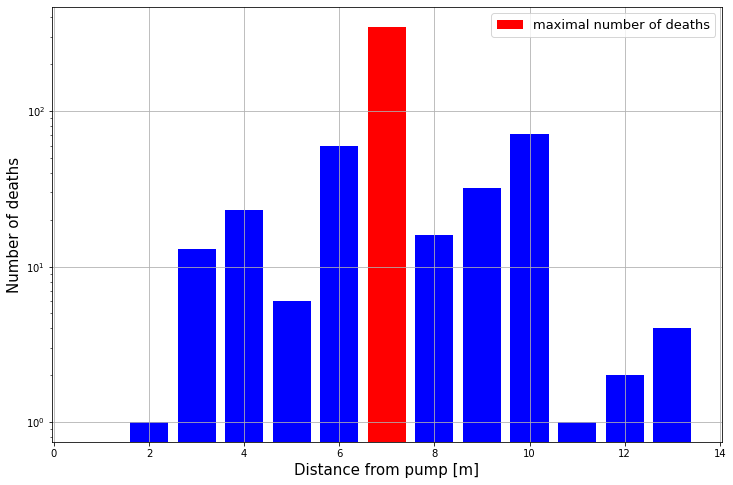

In [31]:
plt.figure(figsize=(12,8))
plt.bar(dnp_arr[0], dnp_arr[1], color='b')
plt.bar(dnp_arr[0][np.argmax(dnp_arr[1])], np.max(dnp_arr[1]), color='red', label='maximal number of deaths')
plt.xlabel('Distance from pump [m]', fontsize=FS)
plt.ylabel('Number of deaths', fontsize=FS)
plt.legend(loc='upper right', fontsize=FS-2)
plt.yscale('log')
plt.grid()
plt.show()

---
## Exercise 6

Create a death density map using 2D Kernel Density Estimation. Display the density and its contours on the map along with the pumps. What is the density value at each of the pumps? Pinpoint the possible source of the infection.

*Use the projected Cartesian coordinate system for this exercise.* 

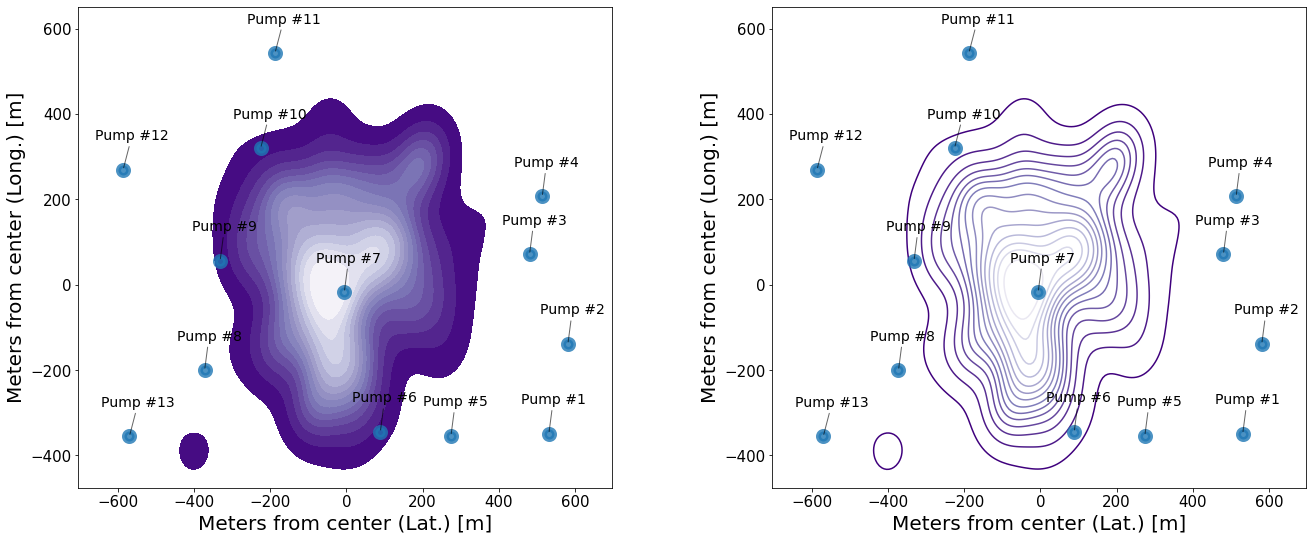

In [32]:
nrows = 1
ncols = 2
f_size = 11
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*f_size, nrows*f_size*size_y/size_x))
fig.subplots_adjust(wspace=0.3)

axislabelsize = 20
axisticksize = 15
s_radius= 10

# KDE plot of deaths
sns.kdeplot(X_d, Y_d, bw='scott',
            shade=True, shade_lowest=False,
            n_levels=15, cmap='Purples_r',
            ax=axes[0], zorder=1)

sns.kdeplot(X_d, Y_d,  bw='scott',
            n_levels=15, cmap='Purples_r',
            ax=axes[1], zorder=1)

for i in range(ncols):
    # Mark pump locations
    axes[i].scatter(X_p, Y_p, label='Pumps',
                    c='C0', marker='o', lw=5, s=s_radius**2, alpha=0.8)
    
    
    for _, p in pumps.iterrows():
        axes[i].annotate('Pump #{0}'.format(p.OBJECTID),
                         xy=(p.lat_proj_rs, p.long_proj_rs), xycoords='data',
                         xytext=(-28, 30), textcoords='offset points', size='14',
                         arrowprops=dict(arrowstyle='-', color='black', alpha=0.6))
    
    axes[i].set_xlabel('Meters from center (Lat.) [m]', fontsize=axislabelsize)
    axes[i].set_ylabel('Meters from center (Long.) [m]', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)
    
    axes[i].set_xlim(min_x*1.2, max_x*1.2)
    axes[i].set_ylim(min_y*1.2, max_y*1.2)
    
plt.show()

In [33]:
XY_d = np.vstack([X_d, Y_d])
XY_p = np.vstack([X_p, Y_p])

# Gaussian KDE by choosing bandwith with Scott's method
kernel = scp.stats.gaussian_kde(dataset=XY_d, bw_method='scott')

In [34]:
# Normalize probabilities for the next estimation
norm = np.sum(kernel(XY_p))

# Estimate probabilities of pumps being dangerous
print('Probability of poisoning of')
for idx, xy in enumerate(XY_p.T):
    if idx < 9:
        print(f'pump  #{idx+1}: P = {round(kernel(xy)[0]/norm*100, 4)} %')
    else:
        print(f'pump #{idx+1}: P = {round(kernel(xy)[0]/norm*100, 4)} %')
        

Probability of poisoning of
pump  #1: P = 0.0002 %
pump  #2: P = 0.0032 %
pump  #3: P = 0.1566 %
pump  #4: P = 0.8099 %
pump  #5: P = 1.0981 %
pump  #6: P = 7.5381 %
pump  #7: P = 76.9573 %
pump  #8: P = 0.4867 %
pump  #9: P = 5.7234 %
pump #10: P = 6.6584 %
pump #11: P = 0.0053 %
pump #12: P = 0.3673 %
pump #13: P = 0.1955 %


According to this analysis, clearly Pump #7 is the most probable main source of the outbreak.    

---
## Exercise 7

Create a GeoJSON object from the Voronoi cells, put the cells on the map, colored according to the number of deaths (like on a heatmap). Display the results in the notebook.

*[GeoJSON](http://geojson.org/) is a common format that is used in web applications. It is basically a simple key-value dictionary with a predefined structure for storing geographic information. Once loaded into Python, it behaves like a normal Python dictionary, thus creating or modifying it is quite straightforward. When reading or writing to a file, the `json` module is handy. The advice is to write a function that converts a list of coordinates from a polygon into a GeoJSON feature, then add it to your GeoJSON structure.*

In [35]:
polygons = []
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        polygon = Polygon([vor.vertices[i] for i in region])
        polygons.append(polygon)

In [36]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({
    'geometry': pumps['geometry'],
    'deaths': deaths_near_pumps.values()
})

In [37]:
# Normalize death counts for coloring
min_deaths, max_deaths = min(deaths_near_pumps.values()), max(deaths_near_pumps.values())
gdf['normalized_deaths'] = (gdf['deaths'] - min_deaths) / (max_deaths - min_deaths)

colormap = plt.cm.viridis

def get_color(value):
    rgba = colormap(value)
    return f'rgba({rgba[0]*255}, {rgba[1]*255}, {rgba[2]*255}, {rgba[3]})'

gdf['color'] = gdf['normalized_deaths'].apply(get_color)


In [38]:
m = folium.Map(location=[death.lat, death.long], zoom_start=17)

for _, row in gdf.iterrows():
    folium.GeoJson(
        data=row['geometry'].__geo_interface__,
        style_function=lambda feature, color=row['color']: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.6,
        }
    ).add_to(m)

m.save('voronoi_map.html')
m